In [1]:
import numpy as np
import pandas as pd
import networkx as nx

%matplotlib inline

In [2]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = ServiceAccountCredentials.from_json_keyfile_name(
         'protogovbase-37548e28a642.json', scope) # Your json file here

gc = gspread.authorize(credentials)

raw = gc.open("proto-govbase data")

orgs = raw.get_worksheet(0)
tools = raw.get_worksheet(1)

In [3]:
data = tools.get_all_values()
headers = data.pop(0)
types = data.pop(0)

df = pd.DataFrame(data, columns=headers)

In [4]:
df[df.include=='TRUE']

id               name include owner dependencies  \
0    0             cadCAD    TRUE   [0]     [14, 17]   
1    1            Discord    TRUE                      
2    2          Discourse    TRUE                      
3    3    Aragon Platform    TRUE   [5]                
4    4      1Hive Gardens    TRUE   [3]                
7    7  Conviction Voting    TRUE                [3]   
8    8         SourceCred    TRUE   [2]    [9, 1, 2]   
9    9             GitHub    TRUE                      
14  14       numpy (tool)    TRUE               [17]   
16  17             python    TRUE                      
17  18            jupyter    TRUE                      
18  19      CommunityRule    TRUE                      
19  20          Dandelion    TRUE                [3]   

                       users  contributors  
0   [0, 1, 2, 3, 4, 6, 7, 8]  [0, 4, 7, 8]  
1               [0, 1, 2, 8]                
2            [0, 1, 2, 3, 5]                
3         [1, 3, 5, 6, 7, 8]                
4                        [3]                
7                  [3, 4, 7]     [4, 6, 7]  
8            [0, 1, 2, 4, 8]                
9   [0, 1, 2, 3, 4, 5, 6, 7]                
14                     [0,4]      [13, 14]  
16                     [0,4]          [14]  
17                    [0, 4]          [14]  
18                       [0]                
19                    [3, 6]        [3, 6]

In [5]:
o_data = orgs.get_all_values()
o_headers = o_data.pop(0)
o_types = o_data.pop(0)

odf = pd.DataFrame(o_data, columns=o_headers)

In [6]:
odf[odf.include=='TRUE']

id                        name include scale (approx members) tools used
0    0                cadCAD (org)    TRUE                                  
1    1                    Metagame    TRUE                                  
2    2            SourceCred (org)    TRUE                                  
3    3                       1Hive    TRUE                                  
4    4                BlockScience    TRUE                                  
6    6          Aragon Association    TRUE                                  
7    7               Commons Stack    TRUE                                  
8    8  TokenEngineering Community    TRUE                                  
13  13                 numpy (org)    TRUE                                  
14  14              numfocus (org)    TRUE

In [7]:
od = odf[odf.include=='TRUE'].values

In [8]:
od[0]

array(['0', 'cadCAD (org)', 'TRUE', '', ''], dtype=object)

In [9]:
G = nx.DiGraph()

In [10]:
def add_org(g, r):
    nids = [n for n in g.nodes]
    if nids == []:
        nid = 0
    else:
        nid = max(nids)+1
    g.add_node(nid)
    
    g.nodes[nid]['type']='org'
    g.nodes[nid]['oid'] = int(r[0])
    g.nodes[nid]['name'] = r[1]
    g.nodes[nid]['size'] = r[3]

In [11]:
def add_orgs(g, R):
    for r in R:
        add_org(g, r)

In [12]:
def get_nodes_by_type(g, node_type_selection):

    return [node for node in g.nodes if g.nodes[node]['type']== node_type_selection ]

In [13]:
def get_org_node_by_oid(g, oid):
    onids = get_nodes_by_type(g, 'org')
    go = True
    for nid in onids:
        if go:
            val = g.nodes[nid]['oid']
            if val == oid:
                go = False
                return val
    
    return None

In [14]:
add_orgs(G,od)

In [15]:
get_org_node_by_oid(G, 5)

In [16]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))

In [17]:
def add_tool(g, r):
    nids = [n for n in g.nodes]
    if nids == []:
        nid = 0
    else:
        nid = max(nids)+1
    g.add_node(nid)
    
    g.nodes[nid]['type']='tool'
    g.nodes[nid]['tid'] = int(r[0])
    g.nodes[nid]['name'] = r[1]
    
    try:
        owner_id = int(r[3][0])
        g.nodes[nid]['owner'] = get_org_node_by_oid(G, owner_id)
    except:
        g.nodes[nid]['owner'] = None

In [18]:
td = df[df.include=='TRUE'].values

In [19]:
td[0]

array(['0', 'cadCAD', 'TRUE', '[0]', '[14, 17]',
       '[0, 1, 2, 3, 4, 6, 7, 8]', '[0, 4, 7, 8]'], dtype=object)

In [20]:
def add_tools(g, R):
    for r in R:
        add_tool(g, r)

In [21]:
add_tools(G,td)

In [22]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22))

In [23]:
def str2list(x):
    if len(x)>0:
        import ast
        l = ast.literal_eval(x)
        return l
    else:
        return []

In [24]:
def add_edges(g, R):
    #node ids for orgs
    o_nodes = get_nodes_by_type(g, 'org')
    
    #maps the nodes oid to their node id
    oids = { g.nodes[n]['oid']:n for n in o_nodes }
    
    t_nodes = get_nodes_by_type(g, 'tool')
    tids = { g.nodes[n]['tid']:n for n in t_nodes }

    for r in R:
        tid = int(r[0])
        tnid = tids[tid]
        #add user edges
        users = str2list(r[5])
        #user edges go from tool to org
        for u in users:
            try:
                unid = oids[u]
                g.add_edge(tnid,unid)
                g.edges[tnid,unid]['type'] = 'user'
            except:
                str(u)
        
        #contributor edges
        contributors = str2list(r[6])
        #contributor edges go from tools to orgs
        for c in contributors:
            try:
                cnid = oids[c]
                g.add_edge(cnid,tnid)
                g.edges[cnid,tnid]['type'] = 'contributor'
            except:
                str(c)
    
    
        #dependency edges
        dependencies = str2list(r[4])
        #dependency edges go from tools to tools
        for d in dependencies:
            try:
                dnid = tids[d]
                g.add_edge(tnid,dnid)
                g.edges[tnid,dnid]['type'] = 'dependencies'
            except:
                str(d)
            


In [25]:
add_edges(G, td)

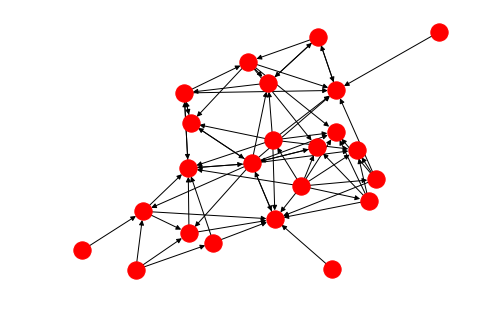

In [26]:
nx.draw_kamada_kawai(G)